# Home-Field Advantage model

Create an 'elo' score (concept borrowed from chess) for teams based on 'fivethirtyeight' website. Compare matchups and favor the home team.

In [1]:
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup

def find_pitchers(team):
    """Import pitching rosters for the 'major cities' teams
    
    Args:
      team (str): the name of the target baseball team
    
    Returns:
      pitchers (list): each pitcher on the 'team's depth chart
    """
    # download contents from the webpage
    url = "https://www.espn.com/mlb/team/depth/_/name/{}/"
    data = requests.get(url.format(team)).text
    soup = BeautifulSoup(data, 'html.parser')
    
    # a list of all tables
    tables = soup.find_all('table')
    table = soup.find('table', class_='Table')
    
    df = pd.DataFrame(columns=['starter','2nd','3rd','4th','5th'])
    
    # collecting data
    for row in tables[1].tbody.find_all('tr'):
        columns = row.find_all('td')
        if (columns != []):
            starter = columns[0].text.strip()
            second = columns[1].text.strip()
            third = columns[2].text.strip()
            fourth = columns[3].text.strip()
            fifth = columns[4].text.strip()

            df = df.append({
                'starter': starter,
                '2nd': second,
                '3rd': third,
                '4th': fourth,
                '5th': fifth
            }, ignore_index=True)

    pitchers = list(df.iloc[0]) + list(df.iloc[1])
    return pitchers

In [2]:
# generate an ELO dictionary

elo_url = "https://projects.fivethirtyeight.com/2022-mlb-predictions/"
page = requests.get(elo_url).text

soup = BeautifulSoup(page, 'html.parser')

# check that scraper is working properly
print('Classes of each table:')
for table in soup.find_all('table'):
    print(table.get('class'))
    
# a list of all tables
tables = soup.find_all('table')
# Looking for the table with the class 'Table'
table = soup.find('table', class_='index-standings-table')

# create elo_scores df by web-scraping FiveThirtyEight
elo_scores = pd.DataFrame(columns=['team','division','rating','1wk_change','run_diff','make_playoffs','win_division','win_ws'])

#collecting data
for row in table.tbody.find_all('tr'):
    columns = row.find_all('td')
    
    if (columns != []):
        team = columns[0].text.strip()
        div = columns[1].text.strip()
        rating = columns[2].text.strip()
        week_ch = columns[3].text.strip()
        run_diff = columns[4].text.strip()
        make_playoffs = columns[5].text.strip()
        win_div = columns[6].text.strip()
        win_ws = columns[7].text.strip()
        
        elo_scores = elo_scores.append({
            'team': team,
            'division': div,
            'rating': rating,
            '1wk_change': week_ch,
            'run_diff': run_diff,
            'make_playoffs': make_playoffs,
            'win_division': win_div,
            'win_ws': win_ws
        }, ignore_index=True)

elo_scores = elo_scores.drop(['division','run_diff','make_playoffs','win_division','win_ws'], axis=1)

elo_scores['team'] = elo_scores['team'].str.extract(r'([a-zA-Z]+)')
elo_scores['team'] = elo_scores['team'].apply(lambda x: 'Red Sox' if (x == 'Red') else x)
elo_scores['team'] = elo_scores['team'].apply(lambda x: 'White Sox' if (x == 'White') else x)
elo_scores['team'] = elo_scores['team'].apply(lambda x: 'Blue Jays' if (x == 'Blue') else x)
elo_scores['team'] = elo_scores['team'].apply(lambda x: 'Dbacks' if (x == 'Diamondbacks') else x)

elo_scores = elo_scores.sort_values(by=['rating'], ascending=False).reset_index()
elo_scores = elo_scores.drop(['index'], axis=1)

# create a dictionry to map the gameDay df when ready
elo_dict = elo_scores.set_index('team')['rating'].to_dict()

# scrape BeautifulSoup here to ensure we dont 
# request every time we want to search the same soup
url = "https://www.espn.com/mlb/schedule"
page = requests.get(url)
soup = BeautifulSoup(page.text, 'lxml')

#print elo rankings df
elo_scores

Classes of each table:
['index-standings-table', 'arrow-sort']


,team,rating,1wk_change
0,Dodgers,1619,-3
1,Braves,1580,+7
2,Astros,1571,+3
3,Yankees,1568,-1
4,Mets,1556,-5
5,Blue Jays,1544,+4
6,Rays,1542,+7
7,Cardinals,1536,+3
8,Phillies,1531,
9,Mariners,1529,+7


In [3]:
tag = 'div'
class_ = 'class'
table_name = 'ResponsiveTable'
tables = soup.find_all('{}'.format(tag), {'{}'.format(class_):'{}'.format(table_name)})
table = tables[2]

table_date = table.find('div', {'class':'Table__Title'}).text
print(table_date)

gameDay = pd.DataFrame(columns=['away','home','time','blank','pitching','tickets','odds'])

for row in table.find_all('tr')[1:]:
    data = row.find_all('td')
    if (data != []):
        row_data = [td.text.strip() for td in data]
        length = len(gameDay)
        gameDay.loc[length] = row_data

gameDay = gameDay.drop(['blank','time','tickets','odds'], axis=1)
gameDay

Friday, September 9, 2022 


,away,home,pitching
0,San Francisco,@ Chicago,Carlos Rodon vs Drew Smyly
1,St. Louis,@ Pittsburgh,Miles Mikolas vs Roansy Contreras
2,New York,@ Miami,Undecided vs Edward Cabrera
3,Boston,@ Baltimore,Brayan Bello vs Austin Voth
4,Tampa Bay,@ New York,Corey Kluber vs Frankie Montas
5,Washington,@ Philadelphia,Patrick Corbin vs Noah Syndergaard
6,Toronto,@ Texas,Ross Stripling vs Dane Dunning
7,Los Angeles,@ Houston,Michael Lorenzen vs Lance McCullers Jr.
8,Cincinnati,@ Milwaukee,Nick Lodolo vs Jason Alexander
9,Cleveland,@ Minnesota,Cal Quantrill vs Dylan Bundy


In [4]:
# cleaning 'gameDay'
## this cell should only be ran once
gameDay['home'] = gameDay['home'].apply(lambda x: x.replace('@  ',''))
gameDay['home'] = gameDay['home'].apply(lambda x: x.replace('@ ',''))
gameDay['home'] = gameDay['home'].apply(lambda x: x.replace('\xa0',''))
gameDay['away_pitcher'] = gameDay['pitching'].apply(lambda x: x.split(' vs ')[0])
gameDay['home_pitcher'] = gameDay['pitching'].apply(lambda x: re.split(' vs ',x)[1])
gameDay = gameDay.drop(['pitching'], axis=1)
gameDay

,away,home,away_pitcher,home_pitcher
0,San Francisco,Chicago,Carlos Rodon,Drew Smyly
1,St. Louis,Pittsburgh,Miles Mikolas,Roansy Contreras
2,New York,Miami,Undecided,Edward Cabrera
3,Boston,Baltimore,Brayan Bello,Austin Voth
4,Tampa Bay,New York,Corey Kluber,Frankie Montas
5,Washington,Philadelphia,Patrick Corbin,Noah Syndergaard
6,Toronto,Texas,Ross Stripling,Dane Dunning
7,Los Angeles,Houston,Michael Lorenzen,Lance McCullers Jr.
8,Cincinnati,Milwaukee,Nick Lodolo,Jason Alexander
9,Cleveland,Minnesota,Cal Quantrill,Dylan Bundy


In [5]:
# major city teams have the issue of redundency
# assembling the pitchers allows us to check which team is which
teams = ['nyy','nym','lad','laa','chc','chw']
nyy_pitchers = find_pitchers('nyy')
nym_pitchers = find_pitchers('nym')
lad_pitchers = find_pitchers('lad')
laa_pitchers = find_pitchers('laa')
chc_pitchers = find_pitchers('chc')
chw_pitchers = find_pitchers('chw')

# check on a certain city
# print(nyy_pitchers)
# print(nym_pitchers)

# check 'away' column for Chicago
index_count = 0
for city in gameDay['away']:
    if city == 'Chicago':
        index_count += 1
        if gameDay['away_pitcher'][index_count-1] in chc_pitchers:
            gameDay['away'][index_count-1] = 'Cubs'
        elif gameDay['away_pitcher'][index_count-1] in chw_pitchers:
            gameDay['away'][index_count-1] = 'White Sox'
        else:
            print('***Error with Chicago-Away***')
    else:
        index_count += 1
        continue

# check 'home' column for Chicago
index_count = 0
for city in gameDay['home']:
    if city == 'Chicago':
        index_count += 1
        if gameDay['home_pitcher'][index_count-1] in chc_pitchers:
            gameDay['home'][index_count-1] = 'Cubs'
        elif gameDay['home_pitcher'][index_count-1] in chw_pitchers:
            gameDay['home'][index_count-1] = 'White Sox'
        else:
            print('***Error with Chicago-Home***')
    else:
        index_count += 1
        continue

# check 'away' column for New York
index_count = 0
for city in gameDay['away']:
    if city == 'New York':
        index_count += 1
        if gameDay['away_pitcher'][index_count-1] in nyy_pitchers:
            gameDay['away'][index_count-1] = 'Yankees'
        elif gameDay['away_pitcher'][index_count-1] in nym_pitchers:
            gameDay['away'][index_count-1] = 'Mets'
        else:
            print('***Error with New York-Away***')
    else:
        index_count += 1
        continue

# check 'home' column for New York
index_count = 0
for city in gameDay['home']:
    if city == 'New York':
        index_count += 1
        if gameDay['home_pitcher'][index_count-1] in nyy_pitchers:
            gameDay['home'][index_count-1] = 'Yankees'
        elif gameDay['home_pitcher'][index_count-1] in nym_pitchers:
            gameDay['home'][index_count-1] = 'Mets'
        else:
            print('***Error with New York-Home***')
    else:
        index_count += 1
        continue

# check 'away' column for Los Angeles
index_count = 0
for city in gameDay['away']:
    if city == 'Los Angeles':
        index_count += 1
        if gameDay['away_pitcher'][index_count-1] in lad_pitchers:
            gameDay['away'][index_count-1] = 'Dodgers'
        elif gameDay['away_pitcher'][index_count-1] in laa_pitchers:
            gameDay['away'][index_count-1] = 'Angels'
        else:
            print('***Error with Los Angeles-Away***')
    else:
        index_count += 1
        continue

# check 'home' column for Los Angeles
index_count = 0
for city in gameDay['home']:
    if city == 'Los Angeles':
        index_count += 1
        if gameDay['home_pitcher'][index_count-1] in lad_pitchers:
            gameDay['home'][index_count-1] = 'Dodgers'
        elif gameDay['home_pitcher'][index_count-1] in laa_pitchers:
            gameDay['home'][index_count-1] = 'Angels'
        else:
            print('***Error with Los Angeles-Home***')
    else:
        index_count += 1
        continue
gameDay

***Error with New York-Away***
***Error with Los Angeles-Away***
***Error with Los Angeles-Away***


,away,home,away_pitcher,home_pitcher
0,San Francisco,Cubs,Carlos Rodon,Drew Smyly
1,St. Louis,Pittsburgh,Miles Mikolas,Roansy Contreras
2,New York,Miami,Undecided,Edward Cabrera
3,Boston,Baltimore,Brayan Bello,Austin Voth
4,Tampa Bay,Yankees,Corey Kluber,Frankie Montas
5,Washington,Philadelphia,Patrick Corbin,Noah Syndergaard
6,Toronto,Texas,Ross Stripling,Dane Dunning
7,Los Angeles,Houston,Michael Lorenzen,Lance McCullers Jr.
8,Cincinnati,Milwaukee,Nick Lodolo,Jason Alexander
9,Cleveland,Minnesota,Cal Quantrill,Dylan Bundy


In [6]:
# use this cell to hard-correct any errors with major cities, if necessary
gameDay['home'][4] = 'Yankees'

In [7]:
# change city name to team name and update 'gameDay'
new_dict = {
    'Tampa Bay': 'Rays','Boston': 'Red Sox','New York': 'Yankees','Toronto': 'Blue Jays','Baltimore': 'Orioles',
    'Chicago': 'White Sox','Cleveland': 'Guardians','Detroit': 'Tigers','Kansas City': 'Royals','Minnesota': 'Twins',
    'Houston': 'Astros','Seattle': 'Mariners','Oakland': 'Athletics','Los Angeles': 'Angels','Texas': 'Rangers',
    'Atlanta': 'Braves','Philadelphia': 'Phillies','New York': 'Mets','Miami': 'Marlins','Washington': 'Nationals',
    'Milwaukee': 'Brewers','St. Louis': 'Cardinals','Cincinnati': 'Reds','Chicago': 'Cubs','Pittsburgh': 'Pirates',
    'San Francisco': 'Giants','Los Angeles': 'Dodgers','San Diego': 'Padres','Colorado': 'Rockies','Arizona': 'Dbacks'
} # trouble spots: New York, Chicago, Los Angeles. Doubles will cause inaccuracies # bug fixed

gameDay = gameDay.replace({'away': new_dict})
gameDay = gameDay.replace({'home': new_dict})
gameDay['a_elo'] = gameDay['away']
gameDay = gameDay.replace({'a_elo': elo_dict})
gameDay['h_elo'] = gameDay['home']
gameDay = gameDay.replace({'h_elo': elo_dict})
gameDay['adv'] = pd.to_numeric(gameDay['h_elo']) - pd.to_numeric(gameDay['a_elo'])
gameDay

,away,home,away_pitcher,home_pitcher,a_elo,h_elo,adv
0,Giants,Cubs,Carlos Rodon,Drew Smyly,1502,1466,-36
1,Cardinals,Pirates,Miles Mikolas,Roansy Contreras,1536,1422,-114
2,Mets,Marlins,Undecided,Edward Cabrera,1556,1465,-91
3,Red Sox,Orioles,Brayan Bello,Austin Voth,1507,1490,-17
4,Rays,Yankees,Corey Kluber,Frankie Montas,1542,1568,26
5,Nationals,Phillies,Patrick Corbin,Noah Syndergaard,1442,1531,89
6,Blue Jays,Rangers,Ross Stripling,Dane Dunning,1544,1471,-73
7,Dodgers,Astros,Michael Lorenzen,Lance McCullers Jr.,1619,1571,-48
8,Reds,Brewers,Nick Lodolo,Jason Alexander,1472,1521,49
9,Guardians,Twins,Cal Quantrill,Dylan Bundy,1506,1507,1


In [8]:
# scrape Fantasy Pros for ranking of pitchers based on fantasy value
pit_url = "https://www.fantasypros.com/mlb/rankings/sp.php"
page = requests.get(pit_url).text
soup = BeautifulSoup(page, 'html.parser')

tables = soup.find_all('table')
pitch = pd.DataFrame(columns=['rank','player','overall',
                              'best','worst','avg',
                              'st_dev','adp','vs_adp'])

#collecting data
for row in tables[0].tbody.find_all('tr'):
    columns = row.find_all('td')
    
    if (columns != []):
        rank = columns[0].text.strip()
        player = columns[1].text.strip()
        overall = columns[2].text.strip()
        best = columns[3].text.strip()
        worst = columns[4].text.strip()
        avg = columns[5].text.strip()
        st_dev = columns[6].text.strip()
        adp = columns[7].text.strip()
        vs_adp = columns[8].text.strip()
        
        pitch = pitch.append({
            'rank': rank,
            'player': player,
            'overall': overall,
            'best': best,
            'worst': worst,
            'avg': avg,
            'st_dev': st_dev,
            'adp': adp,
            'vs_adp': vs_adp
        }, ignore_index=True)

num_pitchers = pitch.shape[0]

# clean player name
pitch['name'] = pitch['player'].str.extract(r'([a-zA-Z]+\s[a-zA-Z]+)\s\(([A-Z]+)')[0]

# get rid of unnecessary columns
pitch.drop(['player','overall','best','worst','avg','adp','st_dev','vs_adp'],
          axis=1,
          inplace=True)

# create pitching boost column
pitch['rank'] = pitch['rank'].astype(int)
pitch['boost'] = (num_pitchers - pitch['rank'])/(num_pitchers/10) 
pitch.drop(['rank'], axis=1, inplace=True)

# create a dictionary to map to the gameDay df
top_pitchers = pitch.set_index('name')['boost'].to_dict()

# change data type of some columns
gameDay['a_elo'] = gameDay['a_elo'].astype(float)
gameDay['h_elo'] = gameDay['h_elo'].astype(float)

# add an empty column
gameDay['a_elo_new'] = np.nan
gameDay['h_elo_new'] = np.nan

# add pitch['boost'] value to either a_elo or h_elo
for i in range(len(gameDay)):
    paway = gameDay['away_pitcher'][i]
    phome = gameDay['home_pitcher'][i]
    aelo = gameDay['a_elo'][i]
    helo = gameDay['h_elo'][i]
    if paway in top_pitchers:
        gameDay['a_elo_new'][i] = aelo + top_pitchers[paway]
    else:
        gameDay['a_elo_new'][i] = aelo
    
    if phome in top_pitchers:
        gameDay['h_elo_new'][i] = helo + top_pitchers[phome]
    else:
        gameDay['h_elo_new'][i] = helo
    
gameDay['adv_new'] = round(gameDay['h_elo_new'] - gameDay['a_elo_new'], 3)
gameDay['a_elo_new'] = round(gameDay['a_elo_new'], 3)
gameDay['h_elo_new'] = round(gameDay['h_elo_new'], 3)
gameDay

/var/folders/x_/9mvkqqv57d7_mn3fvzr8w4v40000gn/T/ipykernel_90368/2036004684.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gameDay['a_elo_new'][i] = aelo + top_pitchers[paway]
/var/folders/x_/9mvkqqv57d7_mn3fvzr8w4v40000gn/T/ipykernel_90368/2036004684.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gameDay['h_elo_new'][i] = helo + top_pitchers[phome]
/var/folders/x_/9mvkqqv57d7_mn3fvzr8w4v40000gn/T/ipykernel_90368/2036004684.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,away,home,away_pitcher,home_pitcher,a_elo,h_elo,adv,a_elo_new,h_elo_new,adv_new
0,Giants,Cubs,Carlos Rodon,Drew Smyly,1502.0,1466.0,-36,1511.220,1471.153,-40.068
1,Cardinals,Pirates,Miles Mikolas,Roansy Contreras,1536.0,1422.0,-114,1541.661,1427.424,-114.237
2,Mets,Marlins,Undecided,Edward Cabrera,1556.0,1465.0,-91,1556.000,1470.288,-85.712
3,Red Sox,Orioles,Brayan Bello,Austin Voth,1507.0,1490.0,-17,1507.000,1490.000,-17.000
4,Rays,Yankees,Corey Kluber,Frankie Montas,1542.0,1568.0,26,1548.949,1577.288,28.339
5,Nationals,Phillies,Patrick Corbin,Noah Syndergaard,1442.0,1531.0,89,1448.339,1538.831,90.492
6,Blue Jays,Rangers,Ross Stripling,Dane Dunning,1544.0,1471.0,-73,1547.729,1477.475,-70.254
7,Dodgers,Astros,Michael Lorenzen,Lance McCullers Jr.,1619.0,1571.0,-48,1619.000,1571.000,-48.000
8,Reds,Brewers,Nick Lodolo,Jason Alexander,1472.0,1521.0,49,1477.966,1521.000,43.034
9,Guardians,Twins,Cal Quantrill,Dylan Bundy,1506.0,1507.0,1,1513.017,1513.102,0.085


In [9]:
# predicted winners/losers put into lists
win_pred = []
lose_pred = []
home_winners = []

# bet on good, home teams
for home in gameDay['home']:
    if home in list(elo_scores['team'].head(11)):
        win_pred.append(home)

# bet on home teams with a significant chance to win at home
for i in range(len(gameDay)):
    if gameDay['adv_new'][i] > 55:
        win_pred.append(gameDay['home'][i])

# bet on away teams with a significant chance to win on the road
# # make sure two opposite bets on the same game dont emerge in the output       
for i in range(len(gameDay)):
    if gameDay['home'][i] not in home_winners:
        if gameDay['adv'][i] < -70:
            win_pred.append(gameDay['away'][i])
    else:
        continue
        
# compile a list of teams to bet against
for away in gameDay['away']:
    if away in list(elo_scores['team'].iloc[-10:]):
        lose_pred.append(away)
        
print('Winners: ', sorted(win_pred))
print('Losers: ', sorted(lose_pred))

Winners:  ['Astros', 'Blue Jays', 'Brewers', 'Cardinals', 'Dodgers', 'Mariners', 'Mets', 'Phillies', 'Phillies', 'White Sox', 'Yankees']
Losers:  ['Nationals', 'Reds', 'Tigers']


Difference value:  11
Current Bankroll:  3795.82
DataFrame 1 Shape:  (1754, 3)
X1:  (1743, 1)
y1:  (1743, 1)
X2:  (978, 1)
y2:  (978, 1)
Slope 1:      1.0240866766628793 
Intercept 1:  1020.9977450167642
Slope 2:      2.7771684749411922 
Intercept 2:  -1244.719834668028


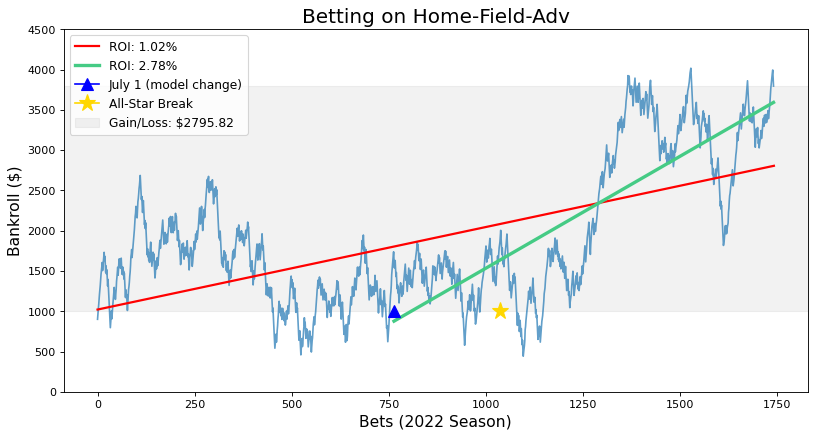

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# read in the Google Sheets - Bets .csv and clean it up
bets = pd.read_csv("/Users/chasecrawford/PycharmProjects/Real Games/09 September 2022/MLB prediction - '538' power ranking - Bets.csv", header=7)
bets = bets.drop(0).reset_index()
bets = bets.drop(['index','date','predicted','bet on','money line','Unnamed: 7'], axis=1)
bets['bankroll'] = bets['bankroll'].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

# 'dif' here figures out how many rows need to be left off the end of the sheet (unpredicted games)
bank_len = [item for item in bets['bankroll'] if not(pd.isnull(item)) == True]
dif = len(bets) - len(bank_len)
print("Difference value: ", dif)

# prepare data for regression
x1 = pd.DataFrame(bets.index)[:-dif]
y1 = bets[['bankroll']][:-dif]

# prepare data for post-July regression
x2 = pd.DataFrame(bets.index)[765:-dif]
y2 = bets[['bankroll']][765:-dif]

# print current bankroll
latest_bankroll = bets['bankroll'].iloc[-(dif+1)]
print("Current Bankroll: ", latest_bankroll)

# print the size of DataFrame 1, to ensure ML compatability
bets_length1 = x1.shape[0]
print("DataFrame 1 Shape: ", bets.shape)
print("X1: ", x1.shape)
print("y1: ", y1.shape)

# print the size of DataFrame 2, to ensure ML compatability
bets_length2 = x2.shape[0]
print("X2: ", x2.shape)
print("y2: ", y2.shape)

# set plot size
plt.figure(figsize=(12, 6), dpi=80)

# plot empirical data
plt.plot(bets['bankroll'], alpha=0.7)

# perform LinearRegression 1
# find elements of y=mx+b for graphing purposes
lr = LinearRegression()
lr.fit(x1, y1)
m = float(lr.coef_)
b = float(lr.intercept_)
#b = 1000
print("Slope 1:     ",m,"\nIntercept 1: ", float(lr.intercept_))
x = np.linspace(0, bets_length1, 1000)
y = m*x + b
plt.plot(x, y, 
         '-r', # red color and line-type
         label="ROI: {:.2f}%".format(m), 
         linewidth=2
        )

# perform LinearRegression 2
# find elements of y=mx+b for graphing purposes
lr2 = LinearRegression()
lr2.fit(x2, y2)
m2 = float(lr2.coef_)
b = float(lr2.intercept_)
print("Slope 2:     ",m2,"\nIntercept 2: ", float(lr2.intercept_))
x = np.linspace(0, bets_length2, 1000) + 764
y3 = m2*x + b
plt.plot(x, y3, 
         '#45CB85', # green color 
         label="ROI: {:.2f}%".format(m2), 
         linewidth=3
        )

# graph settings
plt.title("Betting on Home-Field-Adv", fontsize=18)
plt.xlabel("Bets (2022 Season)", fontsize=14)
plt.xticks()
plt.ylabel("Bankroll (\$)", fontsize=14)
plt.axhspan(1000, latest_bankroll, 
            0, len(bets), 
            color="grey", alpha=0.1, 
            label="Gain/Loss: \${:.2f}".format(latest_bankroll-1000)
           )
plt.plot(764, 1000, 
         label='July 1 (model change)', 
         marker='^', markersize=10, 
         color='b'
        )
plt.plot(1036, 1000, 
         label='All-Star Break', 
         marker='*', markersize=16, 
         color='gold'
        )
plt.legend(fontsize=11)
plt.ylim(0,4500)
plt.show()